In [4]:
import sys
print(sys.path[0])

d:\Programowanie\Python\Envs\ml-pytorch\python311.zip


In [23]:
# ===== IMPORTY (tylko tu) =====
from pathlib import Path
import re, math
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
# ==============================

# --- znajdź root projektu (szukamy .git lub README.md albo best_mos.pth) ---
def find_project_root(start: Path) -> Path:
    cur = start.resolve()
    for p in [cur, *cur.parents]:
        if (p/".git").exists() or (p/"README.md").exists() or (p/"best_mos.pth").exists():
            return p
    return start  # fallback

NB_DIR = Path.cwd()
PROJECT_ROOT = find_project_root(NB_DIR)
print("PROJECT_ROOT:", PROJECT_ROOT)

# --- wybór folderu z klatkami ---
# Jeśli masz klatki bez podfolderu, zostaw FRAMES_DIR = data/frames
# Jeśli masz podfolder (np. Tower_in_Muszyna_MP4), ustaw FILM_DIR_NAME lub automatycznie wykryj.
FILM_DIR_NAME = None  # np. "Tower_in_Muszyna_MP4" albo None żeby wykryć

FRAMES_BASE = PROJECT_ROOT / "data" / "frames"
candidates = [p for p in FRAMES_BASE.glob("*") if p.is_dir()]
if FILM_DIR_NAME:
    FRAMES_DIR = FRAMES_BASE / FILM_DIR_NAME
else:
    # jeśli jest dokładnie jeden podfolder, weź go; jeśli brak podfolderów, użyj base
    FRAMES_DIR = candidates[0] if len(candidates) == 1 else FRAMES_BASE

# --- ścieżki wag i wyników ---
WEIGHTS_PATH = PROJECT_ROOT / "best_mos.pth"
RESULTS_DIR  = PROJECT_ROOT / "results" / FRAMES_DIR.name
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# --- sanity-check ---
frames = sorted([*FRAMES_DIR.glob("*.jpg"), *FRAMES_DIR.glob("*.png"), *FRAMES_DIR.glob("*.jpeg")])
print("FRAMES_DIR:", FRAMES_DIR)
print("Liczba obrazów:", len(frames))
print("Wagi istnieją:", WEIGHTS_PATH.exists(), "→", WEIGHTS_PATH)

assert len(frames) > 0, f"Brak obrazów w {FRAMES_DIR}. Sprawdź czy klatki są we właściwym katalogu."
assert WEIGHTS_PATH.exists(), f"Nie znaleziono wag: {WEIGHTS_PATH}"

# --- urządzenie ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



PROJECT_ROOT: D:\Programowanie\Python\Projects\drone-quality-assessment
FRAMES_DIR: D:\Programowanie\Python\Projects\drone-quality-assessment\data\frames\Fontanna_montt
Liczba obrazów: 17
Wagi istnieją: True → D:\Programowanie\Python\Projects\drone-quality-assessment\best_mos.pth


device(type='cuda')

In [24]:
class CNNforMOS(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        in_features = base.fc.in_features
        base.fc = nn.Identity()
        self.backbone = base
        self.mos = nn.Linear(in_features, 1)
    def forward(self, x):
        f = self.backbone(x)
        return self.mos(f)

model = CNNforMOS().to(device).eval()
state = torch.load(WEIGHTS_PATH, map_location=device)
model.load_state_dict(state)
print("Załadowano wagi:", WEIGHTS_PATH.name, "| device:", device)


Załadowano wagi: best_mos.pth | device: cuda


In [25]:
transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

class FramesFolder(Dataset):
    def __init__(self, folder, transform=None):
        f = Path(folder)
        self.files = sorted([*f.glob("*.jpg"), *f.glob("*.png"), *f.glob("*.jpeg")])
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, i):
        p = self.files[i]
        img = Image.open(p).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, p.name

frames_ds = FramesFolder(FRAMES_DIR, transform_eval)
frames_loader = DataLoader(frames_ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
print("Batchy:", len(frames_loader), "| Obrazów:", len(frames_ds))


Batchy: 1 | Obrazów: 17


In [26]:
rows = []
model.eval()
with torch.inference_mode():
    for imgs, names in frames_loader:
        imgs = imgs.to(device, non_blocking=True)
        mos = model(imgs).squeeze(1).detach().cpu().numpy()  # [B]
        for n, s in zip(names, mos):
            rows.append({"name": n, "mos_pred": float(np.clip(s, 0, 100))})

df_preds = pd.DataFrame(rows).sort_values("mos_pred", ascending=False).reset_index(drop=True)

OUT_CSV = RESULTS_DIR / "drone_mos_predictions.csv"
df_preds.to_csv(OUT_CSV, index=False)
print("Zapisano:", OUT_CSV, "| wierszy:", len(df_preds))

df_preds.head(10)


Zapisano: D:\Programowanie\Python\Projects\drone-quality-assessment\results\Fontanna_montt\drone_mos_predictions.csv | wierszy: 17


,name,mos_pred
0,Fontanna_montt_00h00m30s000ms.jpg,62.640430
1,Fontanna_montt_00h00m12s000ms.jpg,62.175591
2,Fontanna_montt_00h00m28s000ms.jpg,61.468628
3,Fontanna_montt_00h00m14s000ms.jpg,60.861958
4,Fontanna_montt_00h00m16s000ms.jpg,59.611176
5,Fontanna_montt_00h00m20s000ms.jpg,59.586353
6,Fontanna_montt_00h00m02s000ms.jpg,59.495911
7,Fontanna_montt_00h00m22s000ms.jpg,59.444973
8,Fontanna_montt_00h00m08s000ms.jpg,59.183163
9,Fontanna_montt_00h00m24s000ms.jpg,58.786198


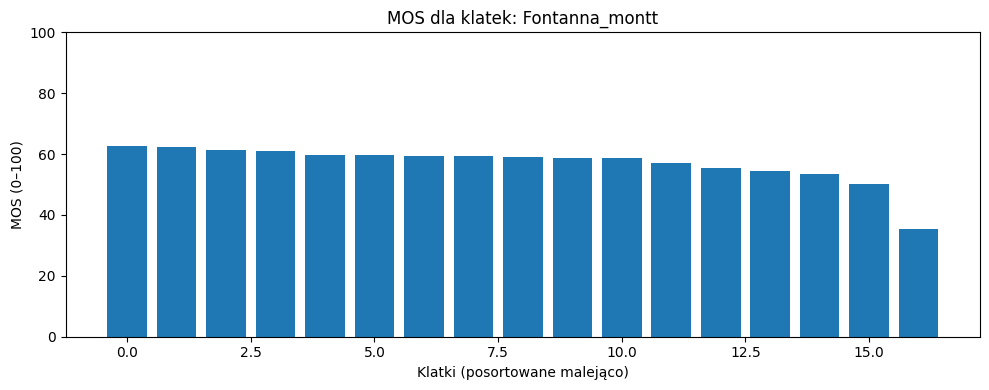

In [27]:
plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(df_preds)), df_preds["mos_pred"])
plt.ylabel("MOS (0–100)")
plt.xlabel("Klatki (posortowane malejąco)")
plt.ylim(0, 100)
plt.title(f"MOS dla klatek: {FRAMES_DIR.name}")
plt.tight_layout()
plt.show()


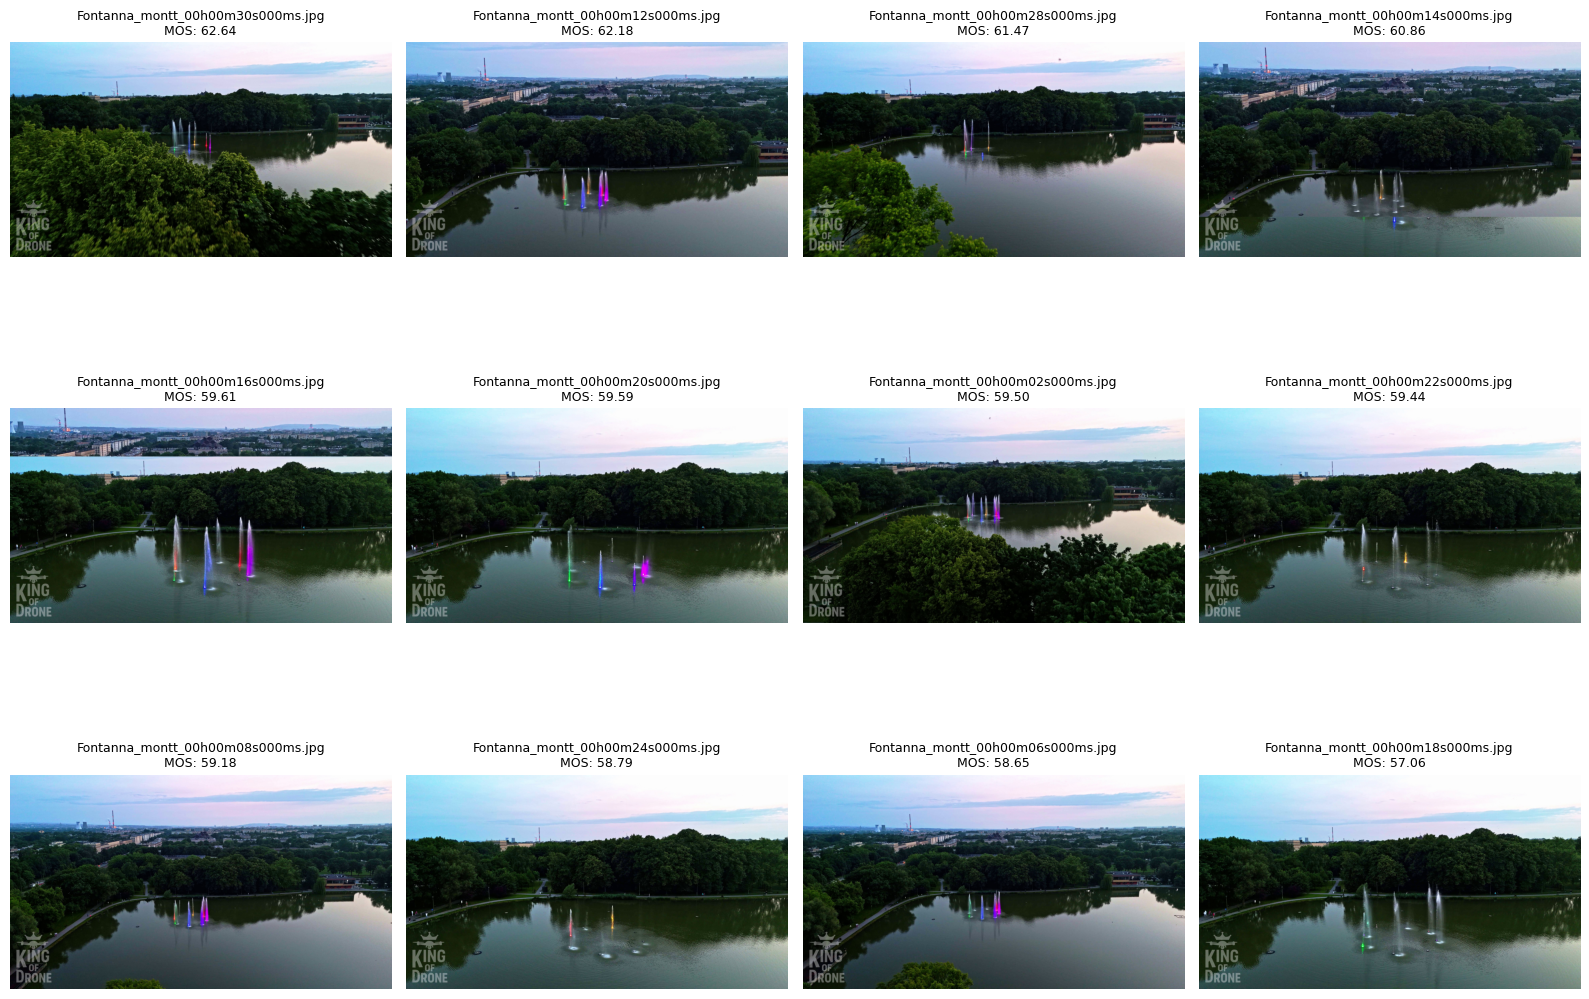

In [28]:
TOP_N = min(12, len(df_preds))  # zmień jeśli chcesz
data = df_preds.head(TOP_N)

COLS = 4
ROWS = math.ceil(TOP_N / COLS)

plt.figure(figsize=(4*COLS, 4*ROWS))
for i, row in enumerate(data.itertuples(index=False)):
    ax = plt.subplot(ROWS, COLS, i+1)
    img_path = FRAMES_DIR / row.name
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception:
        img = Image.new("RGB", (224, 224), color=(220, 220, 220))  # placeholder
    ax.imshow(img); ax.axis("off")
    ax.set_title(f"{row.name}\nMOS: {row.mos_pred:.2f}", fontsize=9)
plt.tight_layout()
plt.show()


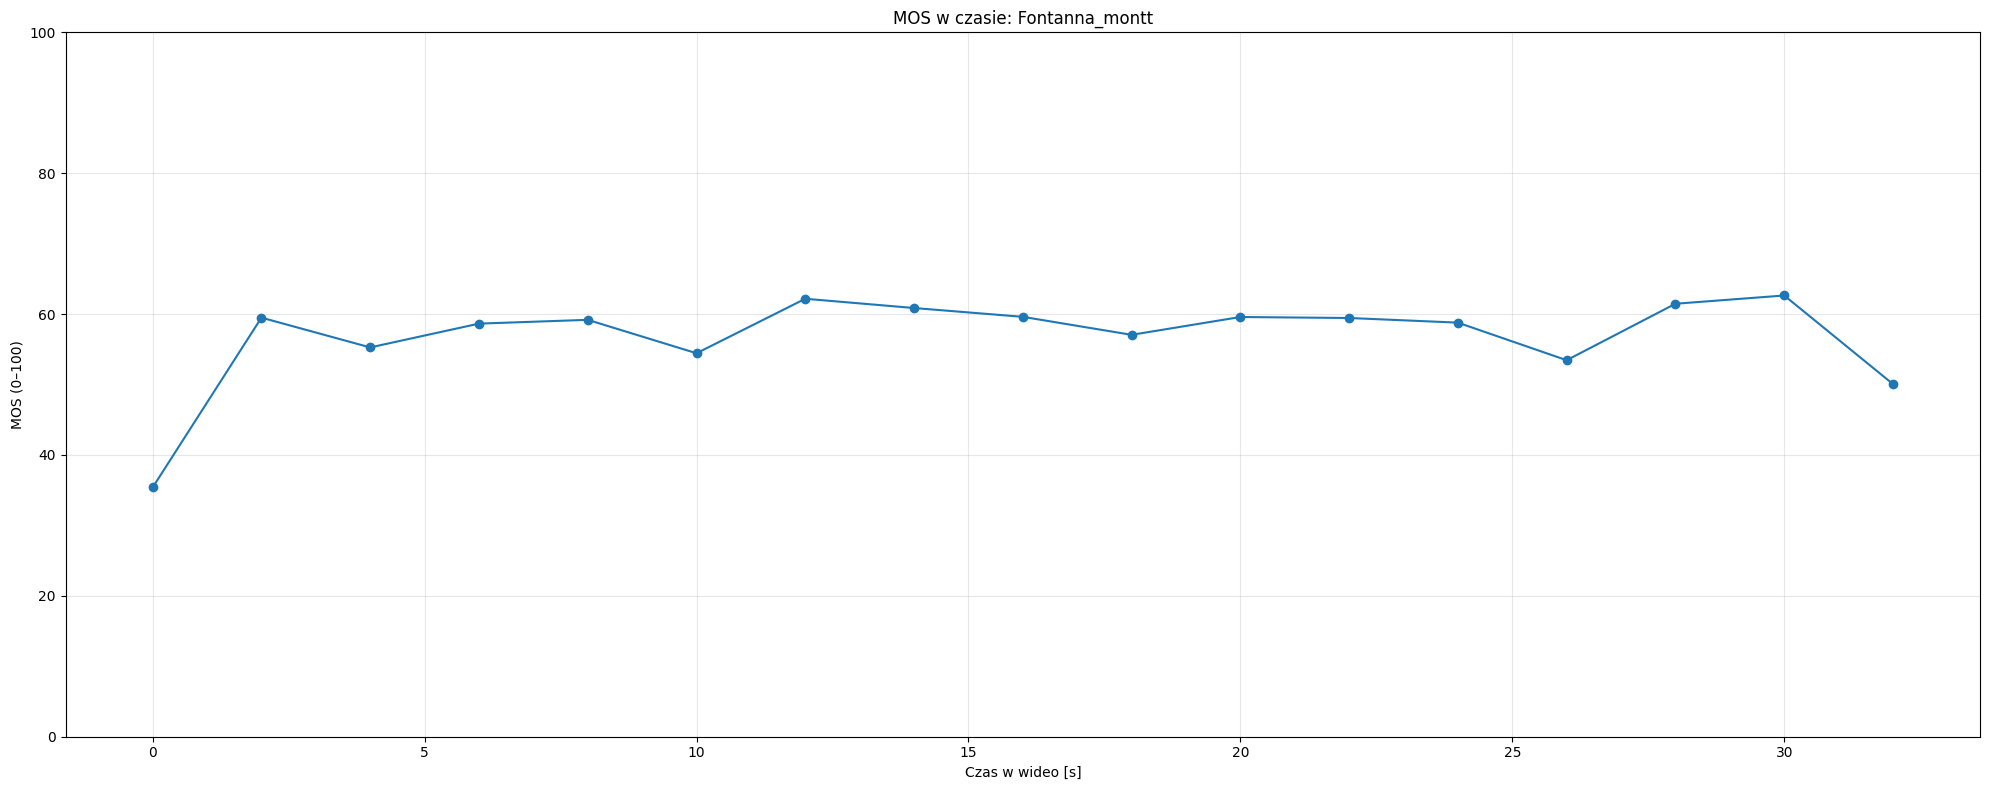

In [30]:
ts_re = re.compile(r'_(\d{2})h(\d{2})m(\d{2})s(\d{3})ms', re.IGNORECASE)

def parse_ts_ms(name: str):
    m = ts_re.search(name)
    if not m:
        return None
    h, m_, s, ms = map(int, m.groups())
    return ((h*60 + m_)*60 + s)*1000 + ms

df_time = df_preds.copy()
df_time["timestamp_ms"] = df_time["name"].map(parse_ts_ms)

if df_time["timestamp_ms"].notna().any():
    df_time = df_time.dropna(subset=["timestamp_ms"]).sort_values("timestamp_ms")
    t_sec = df_time["timestamp_ms"].to_numpy() / 1000.0
    mos   = df_time["mos_pred"].to_numpy()

    plt.figure(figsize=(20, 8))
    plt.plot(t_sec, mos, marker="o")
    plt.xlabel("Czas w wideo [s]")
    plt.ylabel("MOS (0–100)")
    plt.ylim(0, 100)
    plt.title(f"MOS w czasie: {FRAMES_DIR.name}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Brak timestampu w nazwach — pomiń wykres w czasie lub użyj nazw z _00hMMmSSsMSms.")


In [22]:
def append_mos_to_filenames(frames_dir: Path, df: pd.DataFrame, decimals=1):
    for _, r in df.iterrows():
        src = frames_dir / r["name"]
        if not src.exists():
            continue
        stem, ext = src.stem, src.suffix
        if "__mos" in stem:
            continue
        dst = frames_dir / f"{stem}__mos{round(r['mos_pred'],decimals)}{ext}"
        i = 1
        while dst.exists():
            dst = frames_dir / f"{stem}__mos{round(r['mos_pred'],decimals)}_{i}{ext}"
            i += 1
        src.rename(dst)

# Odkomentuj, jeśli chcesz dopisać MOS do nazw:
append_mos_to_filenames(FRAMES_DIR, df_preds, decimals=1)
print("Dopisano __mos do nazw plików.")


Dopisano __mos do nazw plików.
